In [3]:
import numpy as np
from t_test_cpd import TTestCPDetector
import os
import pandas as pd
from typing import List,Tuple
import matplotlib.pyplot as plt
import torch
import random
from cpd_evaluation import binary_evaluation,add_evaluation,nab_evaluation

import matplotlib
font = {'size': 16}

matplotlib.rc('font', **font)

In [4]:
DATASET_PATH = "signal"
EVAL_RESULT_PATH = "eval_fixed"

In [5]:
def get_data_file_list(dataset_path: str) -> List[str]:
    return os.listdir(dataset_path)

In [6]:
def read_dataset(csv_path: str) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path)
    return df["signal"].to_numpy(), df["is_change_point"].to_numpy(dtype=np.int32)

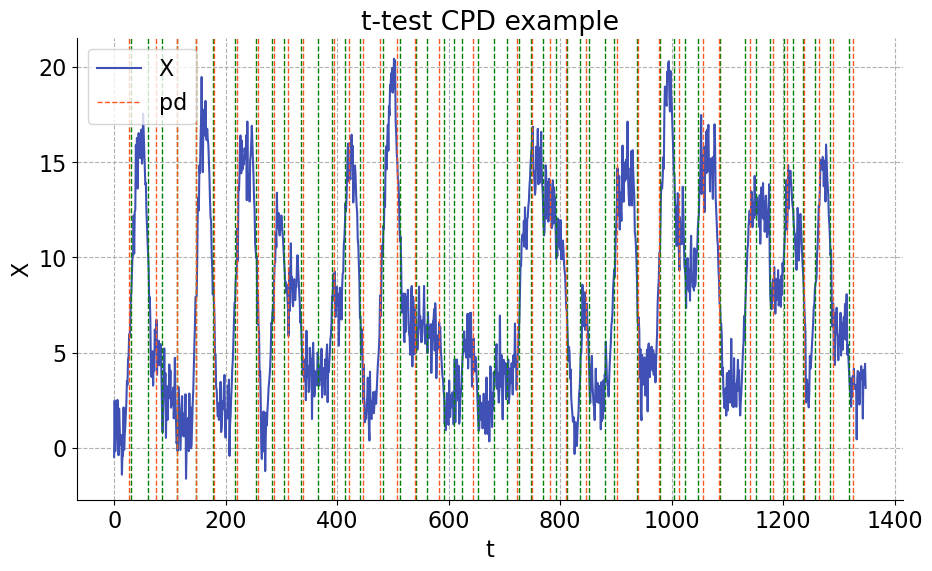

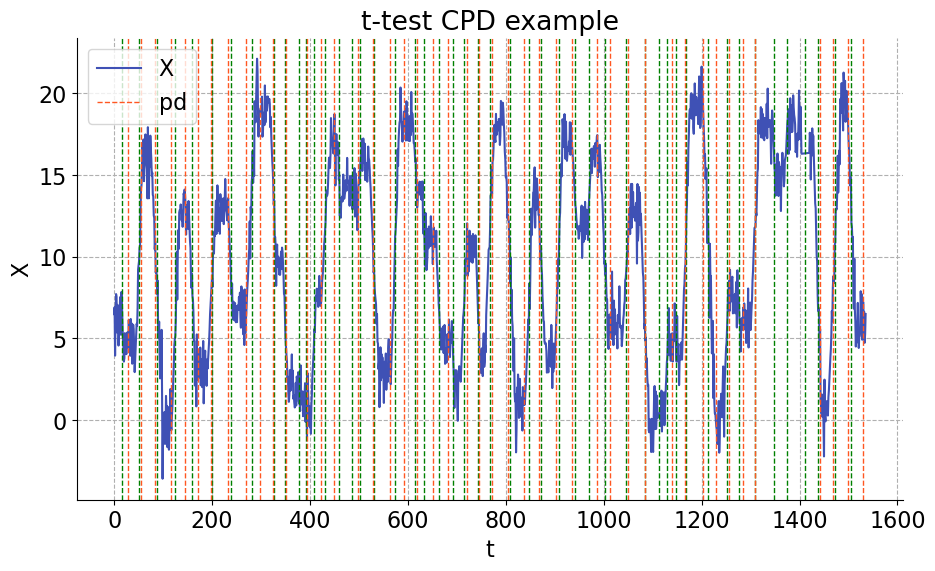

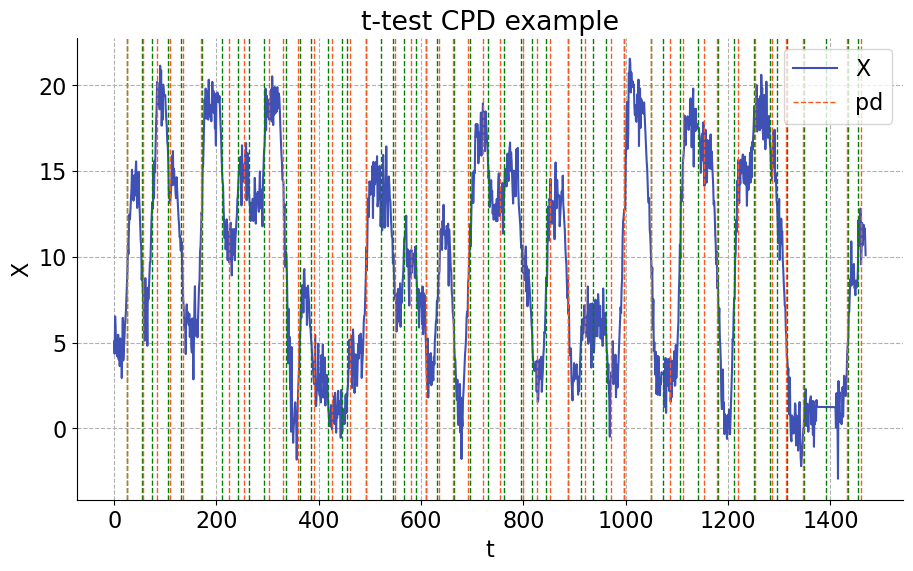

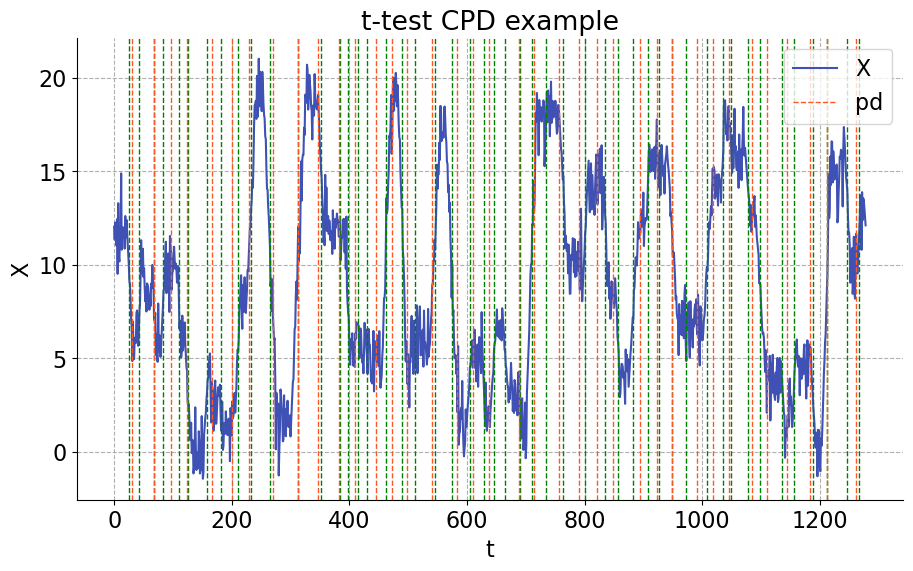

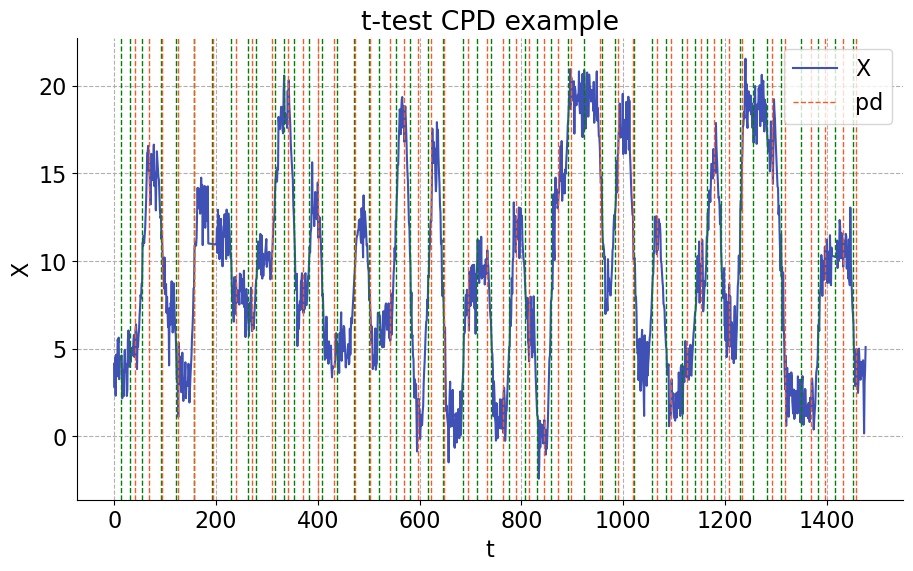

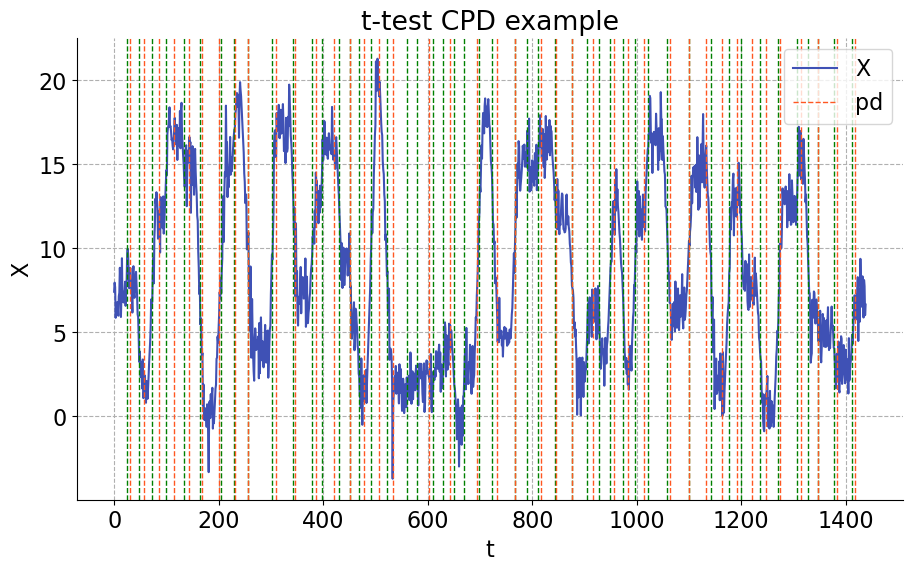

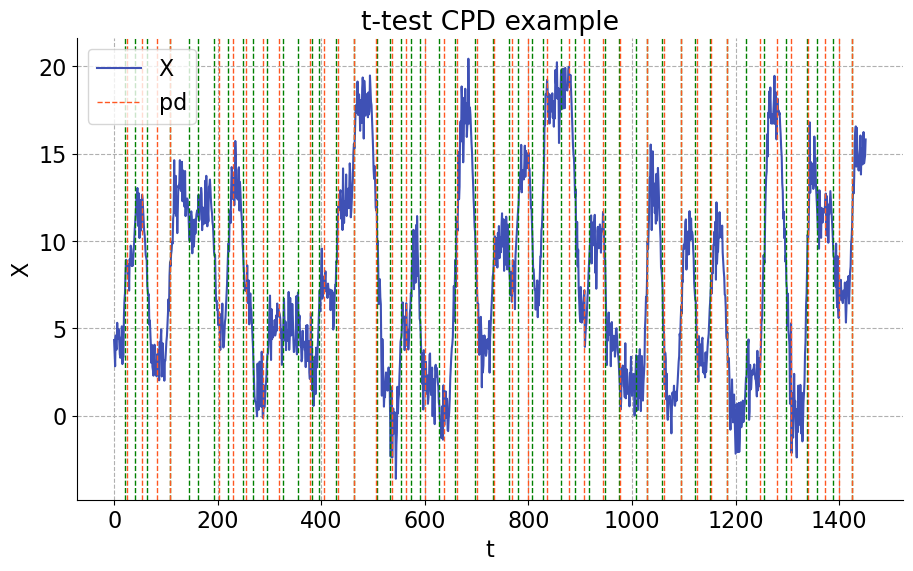

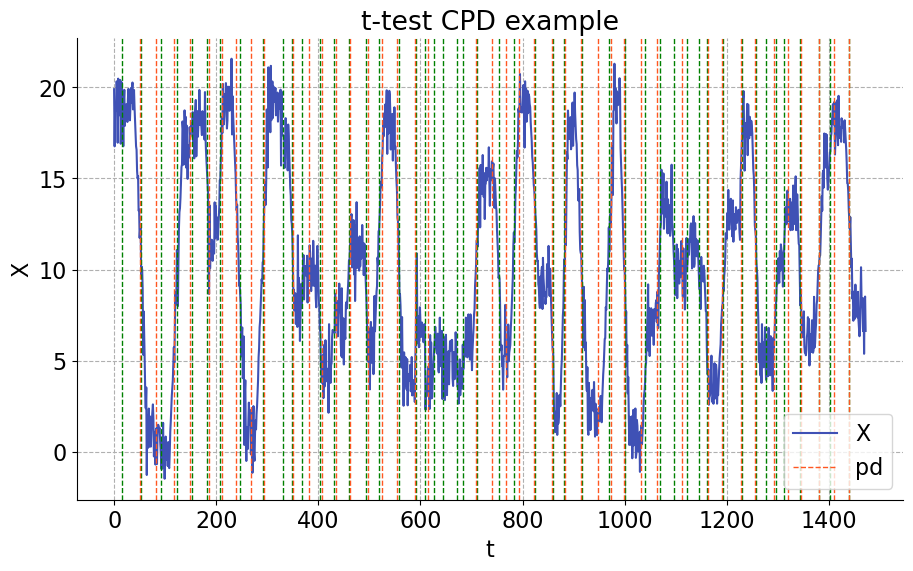

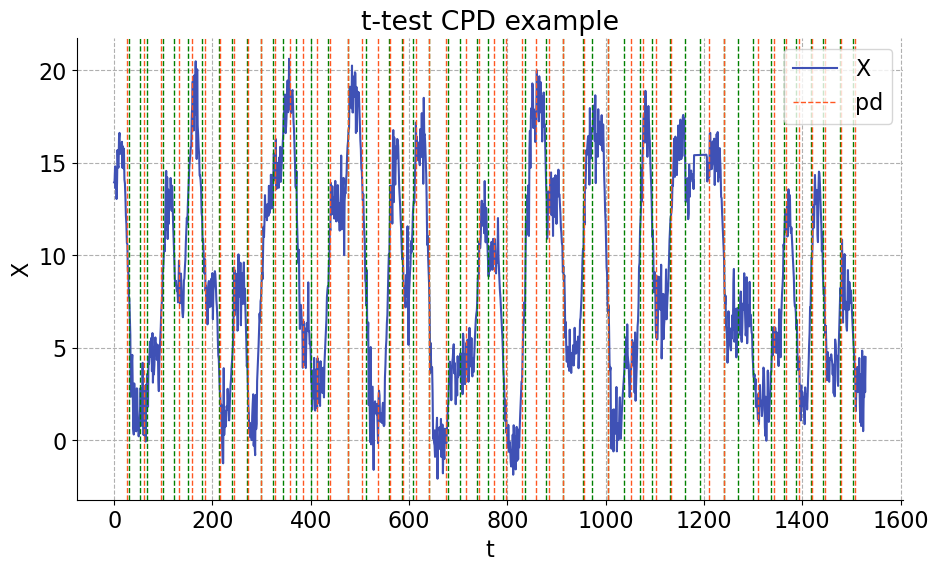

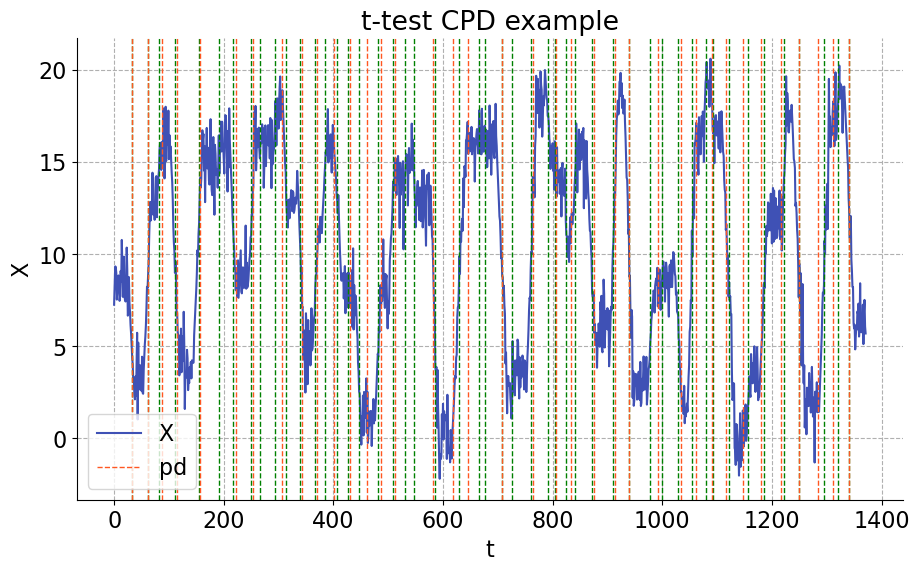

In [7]:
precision_dict = {}
recall_dict = {}
f1_dict = {}
missing_rate_dict = {}
add_dict = {}
nab_dict = {}
for file in get_data_file_list(DATASET_PATH):
    signal, is_change_point = read_dataset(os.path.join(DATASET_PATH, file))
    t_test_detector = TTestCPDetector(20, 0.05)
    pd_change_idx = []
    for idx, x in enumerate(signal):
        _, is_change = t_test_detector.predict_next(x)
        if is_change:
            pd_change_idx.append(idx)
    fig, ax = plt.subplots()
    fig.set_size_inches(16/1.5, 6)
    ax.plot(np.arange(len(signal)), signal, label='X', color="#3F51B5")
    for gt in np.where(is_change_point)[0]:
        plt.axvline(x=gt, color='green', linestyle='--', linewidth=1)
    cpd_line = None
    for cp in pd_change_idx:
        cpd_line = ax.axvline(x=cp, linestyle='--', linewidth=1, color="#FF5722")
    cpd_line.set_label("pd")

    pd_change_onehot = [0]*len(signal)
    for cp in pd_change_idx:
        pd_change_onehot[cp] = 1
    pd_change_onehot = np.array(pd_change_onehot, dtype=np.int32)

    precision, recall, f1, missing_rate = binary_evaluation(is_change_point, pd_change_onehot, 8)
    add, _ = add_evaluation(is_change_point, pd_change_onehot, 8)
    nab = nab_evaluation(is_change_point, pd_change_onehot, 8)

    file_name = file.split(".")[0]
    precision_dict[file_name] = precision
    recall_dict[file_name] = recall
    f1_dict[file_name] = f1
    missing_rate_dict[file_name] = missing_rate
    add_dict[file_name] = add
    nab_dict[file_name] = nab

    ax.set_xlabel('t')
    ax.set_ylabel('X')
    ax.set_title("t-test CPD example")
    ax.legend()
    ax.grid(True, linestyle="--")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.show()
    # plt.close()
    # break

if not os.path.exists(EVAL_RESULT_PATH):
    os.makedirs(EVAL_RESULT_PATH)
df_dict = {}
df_dict["signal_name"] = list(precision_dict.keys())
df_dict["precision"] = list(precision_dict.values())
df_dict["recall"] = list(recall_dict.values())
df_dict["f1"] = list(f1_dict.values())
df_dict["missing_rate"] = list(missing_rate_dict.values())
df_dict["add"] = list(add_dict.values())
df_dict["nab"] = list(nab_dict.values())
pd.DataFrame.from_dict(df_dict).to_csv(os.path.join(EVAL_RESULT_PATH,"eval.csv"),index=False)